In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/proyecto2-files/PRSA_Data_Guanyuan_20130301-20170228.csv
/kaggle/input/proyecto2-files/PRSA_Data_Aotizhongxin_20130301-20170228.csv
/kaggle/input/proyecto2-files/PRSA_Data_Wanliu_20130301-20170228.csv
/kaggle/input/proyecto2-files/PRSA_Data_Tiantan_20130301-20170228.csv
/kaggle/input/proyecto2-files/PRSA_Data_Wanshouxigong_20130301-20170228.csv
/kaggle/input/proyecto2-files/PRSA_Data_Nongzhanguan_20130301-20170228.csv
/kaggle/input/proyecto2-files/PRSA_Data_Shunyi_20130301-20170228.csv
/kaggle/input/proyecto2-files/PRSA_Data_Changping_20130301-20170228.csv
/kaggle/input/proyecto2-files/PRSA_Data_Dingling_20130301-20170228.csv
/kaggle/input/proyecto2-files/PRSA_Data_Huairou_20130301-20170228.csv
/kaggle/input/proyecto2-files/test.csv
/kaggle/input/proyecto2-files/data.csv
/kaggle/input/proyecto2-files/PRSA_Data_Gucheng_20130301-20170228.csv
/kaggle/input/proyecto2-files/PRSA_Data_Dongsi_20130301-20170228.csv


In [2]:
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
from collections import Counter
import glob
import statistics
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
# 'metrics' from sklearn is used for evaluating the model performance
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

# import various functions from statsmodel to perform linear regression
import statsmodels 
import statsmodels.api as sm
import statsmodels.stats.api as stats
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder

## Cargar datos y preprocesamiento

In [3]:
# read data from all files
filePath = '/kaggle/input/proyecto2-files'
allFiles = glob.glob(filePath + "/*20170228.csv")
dataFrames = []
for i in allFiles:
    df = pd.read_csv(i, index_col=None, header=0)
    dataFrames.append(df)
data = pd.concat(dataFrames)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420768 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 61.0+ MB


Interpretation: we find some values are null so threat missing values

In [4]:
# Threat of missing values
data['PM2.5'].fillna(data['PM2.5'].median(), inplace=True)
data['PM10'].fillna(data['PM10'].median(), inplace=True)
data['SO2'].fillna(data['SO2'].median(), inplace=True)
data['NO2'].fillna(data['NO2'].mean(), inplace=True)
data['CO'].fillna(data['CO'].median(), inplace=True)
data['O3'].fillna(data['O3'].median(), inplace=True)
data['TEMP'].fillna(data['TEMP'].median(), inplace=True)
data['PRES'].fillna(data['PRES'].median(), inplace=True)
data['DEWP'].fillna(data['DEWP'].mean(), inplace=True)
data['RAIN'].fillna(data['RAIN'].median(), inplace=True)
data['WSPM'].fillna(data['WSPM'].median(), inplace=True)

## Analisis de datos

In [5]:
# describe data information 
data.drop(['year','month','day','hour'],axis=1).describe().transpose()


,count,mean,std,min,25%,50%,75%,max
No,420768.0,17532.500000,10122.116943,1.0000,8766.75,17532.5,26298.25,35064.0
PM2.5,420768.0,79.278489,80.056799,2.0000,21.00,55.0,109.00,999.0
PM10,420768.0,104.256193,91.108745,2.0000,36.00,82.0,144.00,999.0
SO2,420768.0,15.641507,21.455419,0.2856,3.00,7.0,19.00,500.0
NO2,420768.0,50.638586,34.618463,1.0265,24.00,45.0,70.00,290.0
CO,420768.0,1214.493362,1133.542988,100.0000,500.00,900.0,1500.00,10000.0
O3,420768.0,56.981874,55.802413,0.2142,12.00,45.0,80.00,1071.0
TEMP,420768.0,13.539885,11.430768,-19.9000,3.10,14.5,23.20,41.6
PRES,420768.0,1010.746658,10.469168,982.4000,1002.30,1010.4,1019.00,1042.8
DEWP,420768.0,2.490822,13.787240,-43.4000,-8.90,3.0,15.10,29.1


In [6]:
#Check Standard Deviation is Zero, if any remove from the analisis
data.std()

No       10122.116943
year         1.177198
month        3.448707
day          8.800102
hour         6.922195
PM2.5       80.056799
PM10        91.108745
SO2         21.455419
NO2         34.618463
CO        1133.542988
O3          55.802413
TEMP        11.430768
PRES        10.469168
DEWP        13.787240
RAIN         0.820626
WSPM         1.245947
dtype: float64

In [7]:
temp = data.copy()

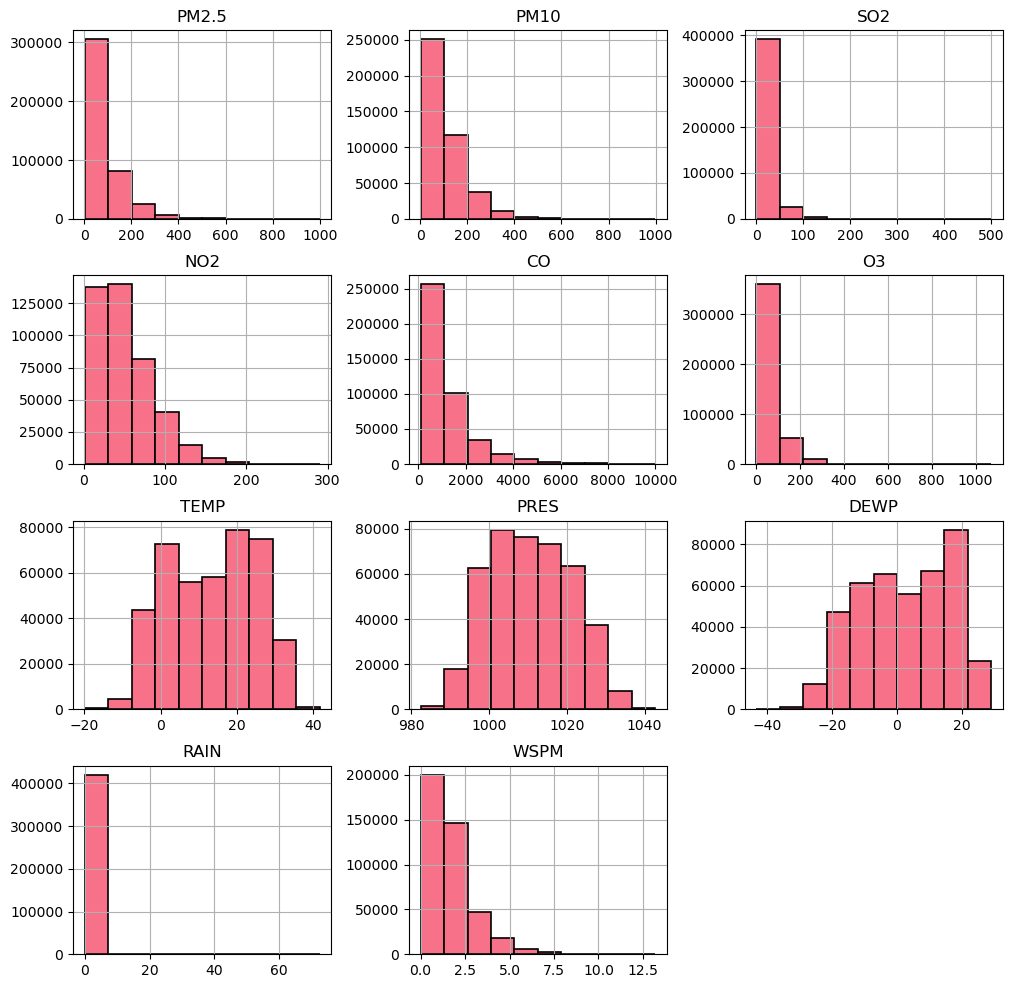

In [8]:
# graphic representation of each pollution value
temp = temp.drop(['year','No','month','day','hour'], axis=1)
temp.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(12,12)
plt.show()

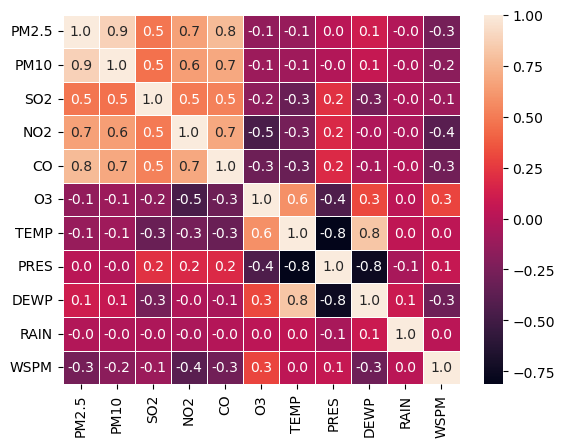

In [9]:
# Verify correlation between fields
sns.heatmap(temp.corr(),
            annot=True, linewidths=.5, fmt= '.1f')
plt.show()

Interpretation: Relatively high correlation seen among CO, NO2, SO2, PM10 and PM2.5 and also between O3 and temp

Annual

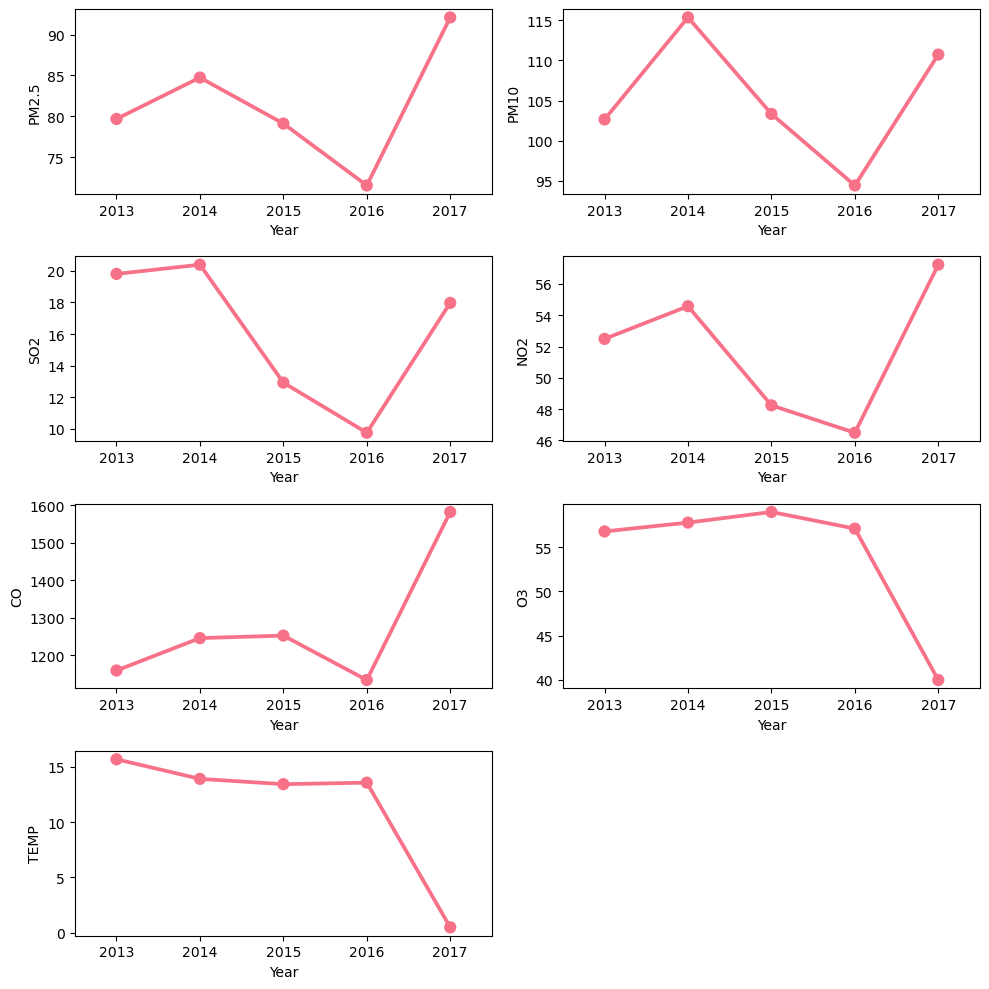

In [10]:
compounds = ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3", "TEMP"]

num_plots = len(compounds)
num_rows = (num_plots + 1) // 2  # Calculate the number of rows for the subplot grid

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(10, 10))

for i, compound in enumerate(compounds):
    row = i // 2
    col = i % 2
    
    df = data[[compound, 'year']].groupby(["year"]).mean().reset_index().sort_values(by='year', ascending=False)
    
    sns.pointplot(x='year', y=compound, data=df, ax=axes[row][col])
    axes[row][col].set_xlabel('Year')
    axes[row][col].set_ylabel(compound)
    
# If the number of compounds is odd, remove the last subplot
if num_plots % 2 == 1:
    fig.delaxes(axes[num_rows - 1, 1])
    
plt.tight_layout()
plt.show()

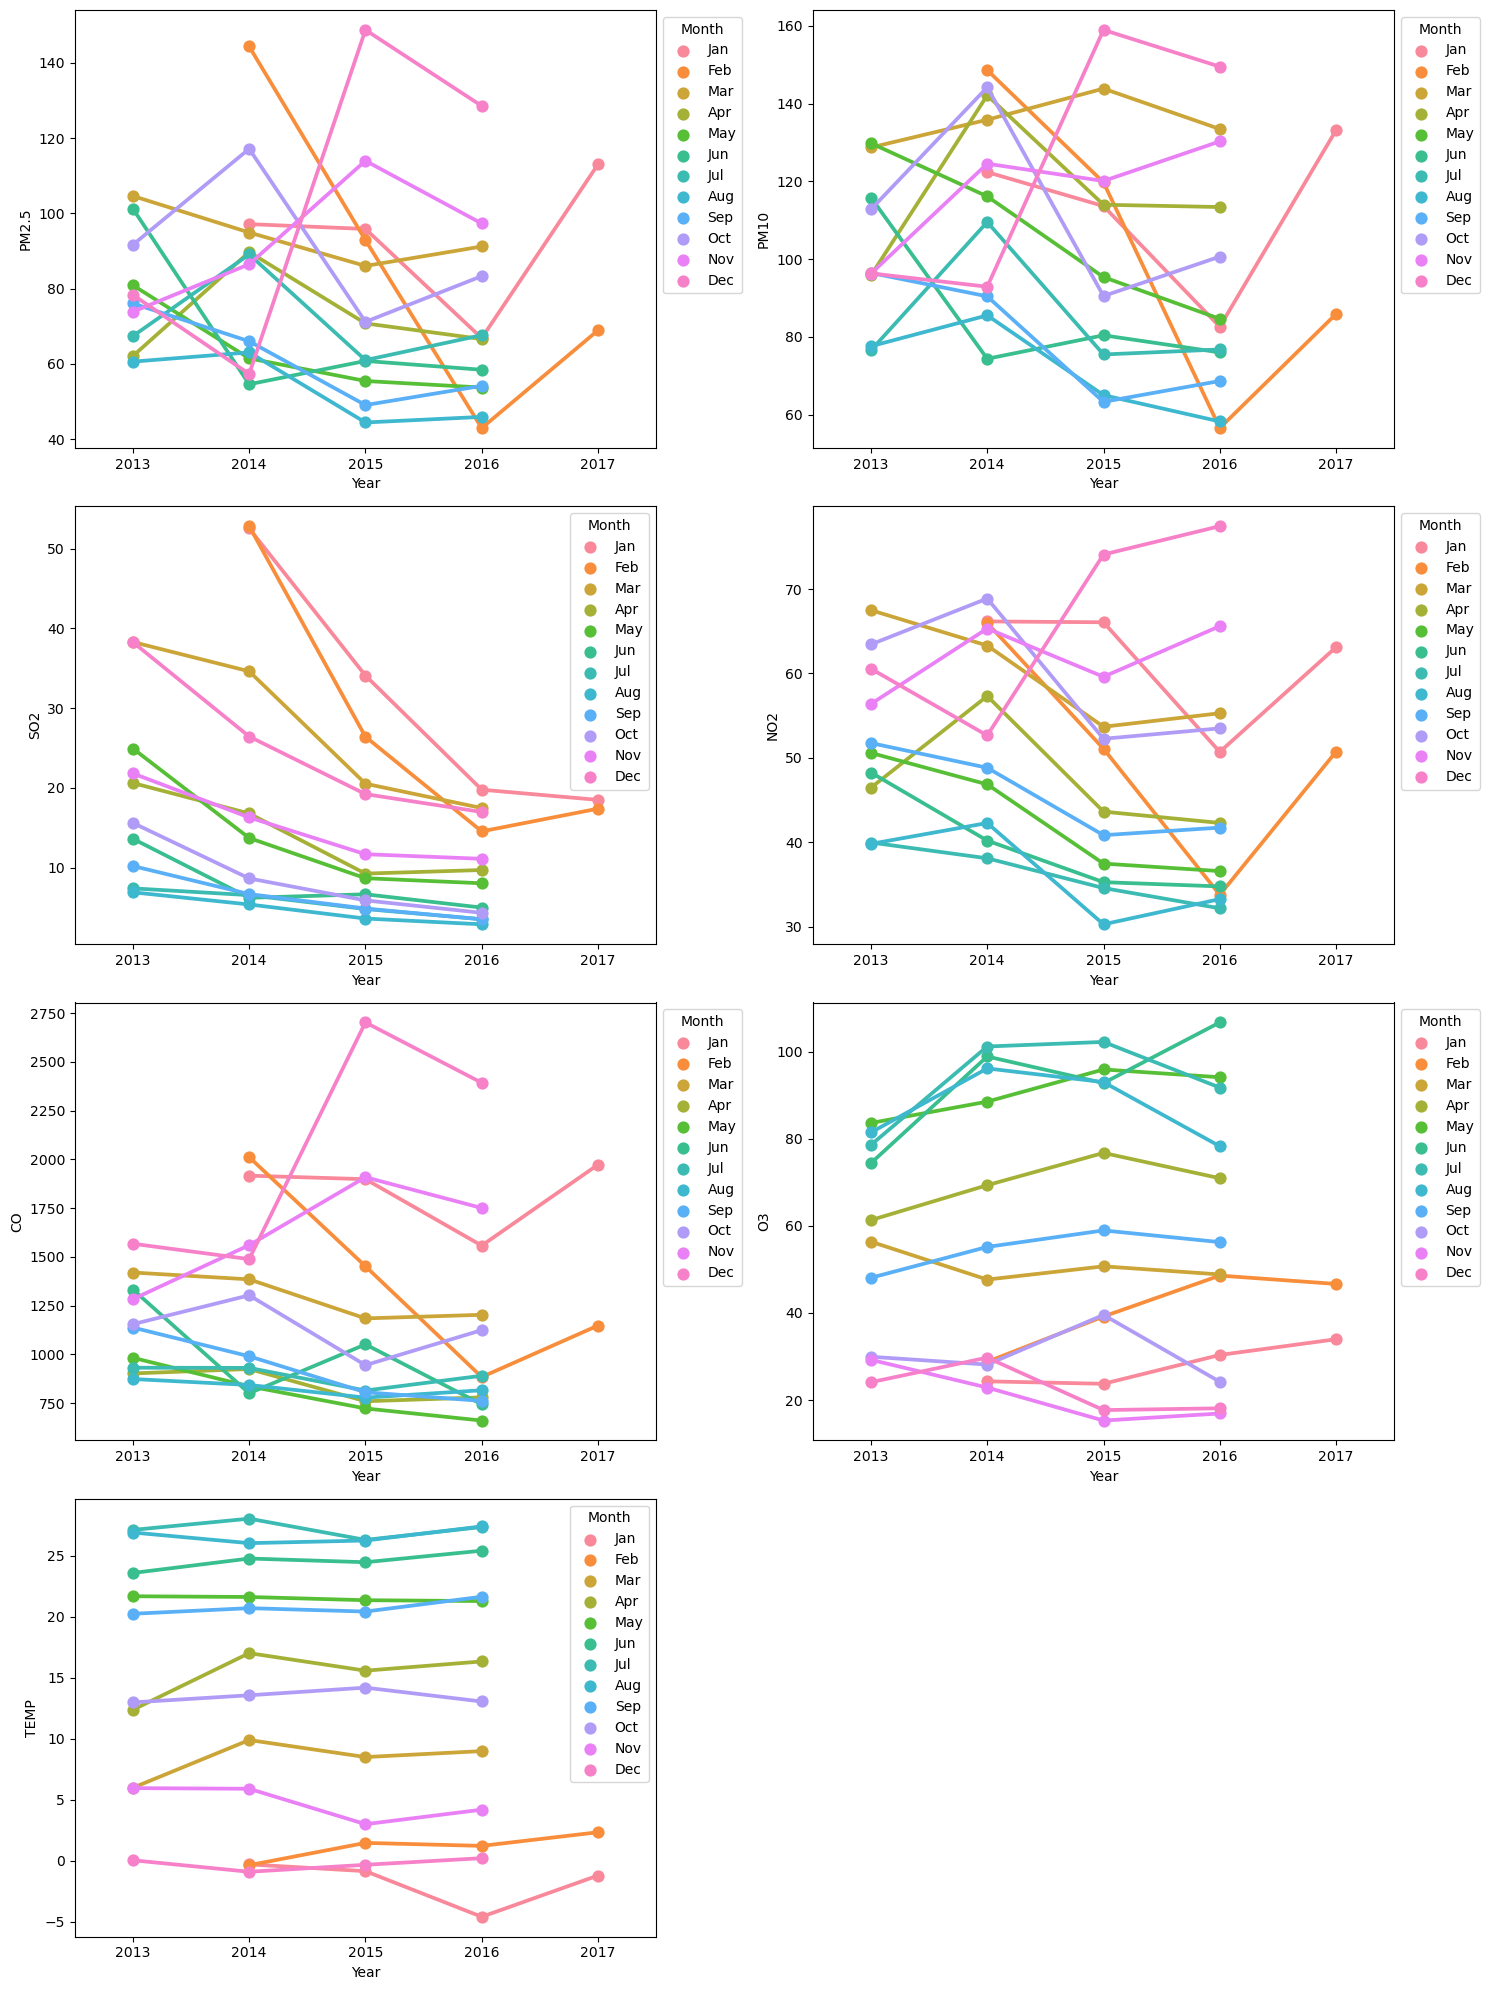

In [11]:
num_compounds = len(compounds)
num_rows = (num_compounds + 1) // 2  # Calculate the number of rows for the subplot grid

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 5 * num_rows))
for i, compound in enumerate(compounds):
    row = i // 2
    col = i % 2

    temp_data = data.copy()
    temp_data.month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                                                           'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
    df = temp_data[[compound, 'month', 'year']].groupby(["year", "month"]).mean().reset_index().sort_values(by=['year', 'month'], ascending=False)

    sns.pointplot(x='year', y=compound, data=df, hue='month', hue_order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ax=axes[row][col])
    axes[row][col].set_xlabel('Year')
    axes[row][col].set_ylabel(compound)
    axes[row][col].legend(title='Month', bbox_to_anchor=(1, 1))

# If the number of compounds is odd, remove the last subplot
if num_compounds % 2 == 1:
    fig.delaxes(axes[num_rows - 1, 1])

plt.tight_layout()
plt.show()

Observamos comportamiento parecido en todas las variables que se correlacionan comparado con los años

Analisis mensual

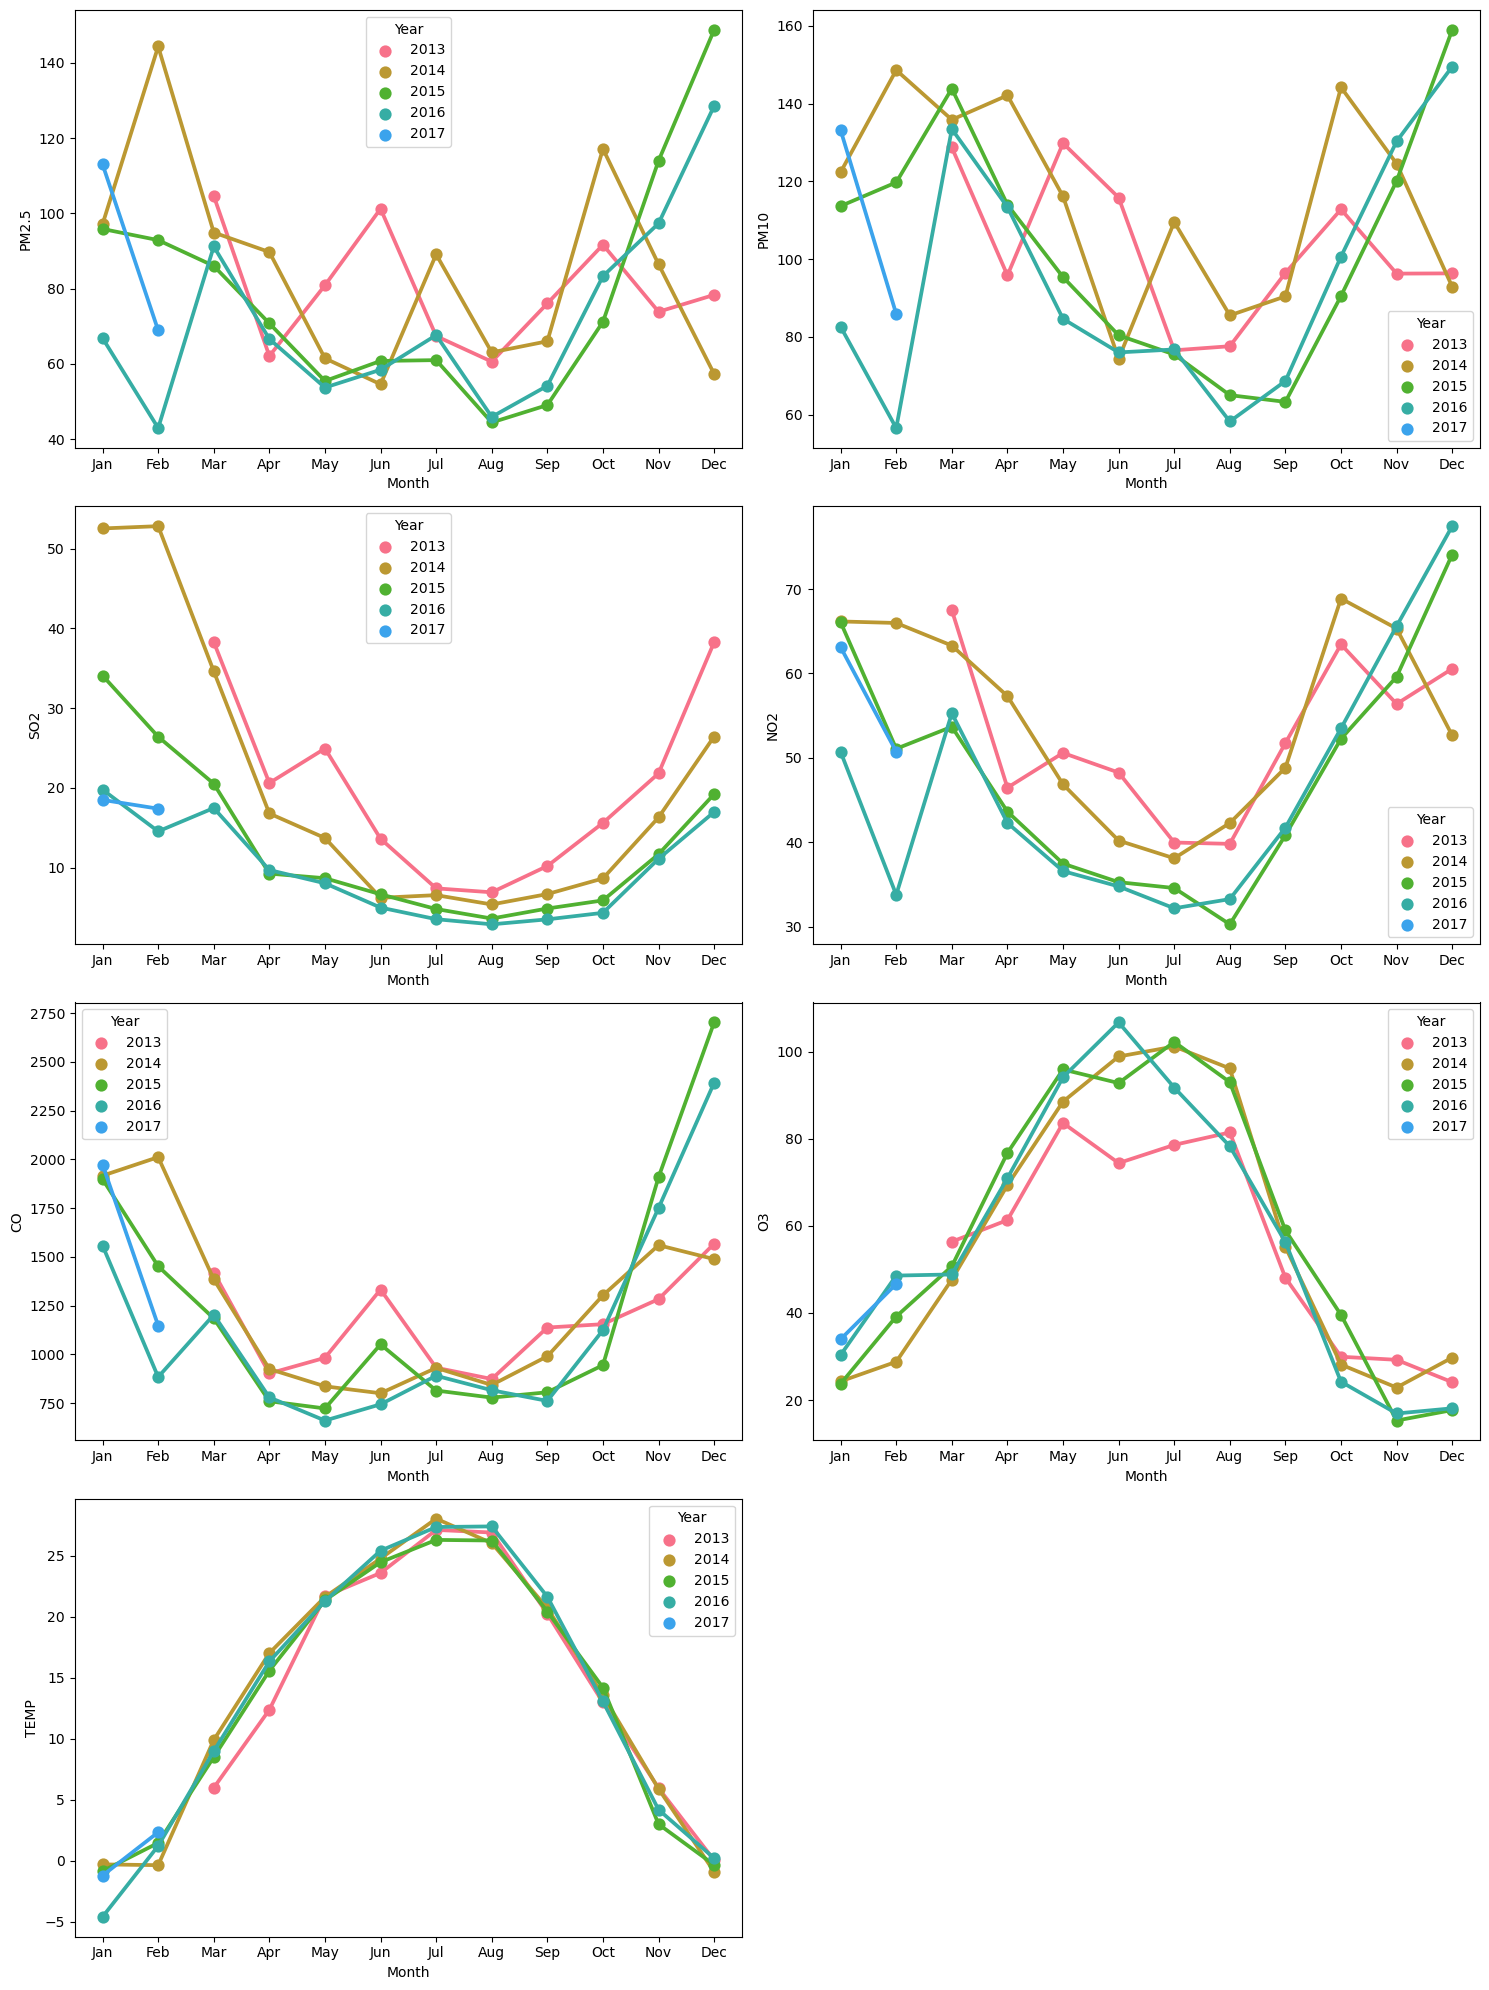

In [12]:
custom_dict = {'Jan':0, 'Feb':1, 'Mar':2, 'Apr':3, 'May':4, 'Jun':5,
               'Jul':6, 'Aug':7, 'Sep':8, 'Oct':9, 'Nov':10, 'Dec':11}
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 5 * num_rows))

for i, compound in enumerate(compounds):
    row = i // 2
    col = i % 2

    temp_data = data.copy()
    temp_data.month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                                                           'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)

    df = temp_data[[compound, 'month', 'year']].groupby(["year", "month"]).mean().reset_index().sort_values(
        by=['year', 'month'], ascending=True)

    df['month'] = df['month'].map(custom_dict)  # Map custom month order

    df = df.sort_values(by=['month', 'year'])  # Sort by custom month order and then by year
    df.month.replace([0,1,2,3,4,5,6,7,8,9,10,11], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                                                           'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
    
    sns.pointplot(x='month', y=compound, data=df, hue='year', ax=axes[row, col])
    axes[row, col].set_xlabel('Month')
    axes[row, col].set_ylabel(compound)
    axes[row, col].legend(title='Year')

# If the number of compounds is odd, remove the last subplot
if num_compounds % 2 != 0:
    fig.delaxes(axes[num_rows - 1, 2 - 1])

plt.tight_layout()
plt.show()

El analizis de graficas sugiere que durante todos los años en la mayoria de variables se repite el mismo patron de comportamiento a travez de los meses

Analisis por dia

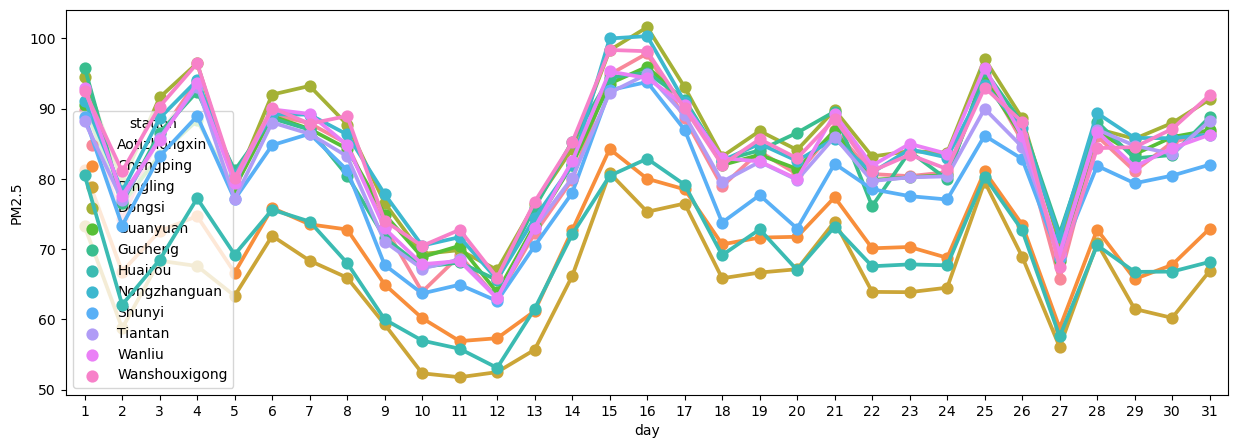

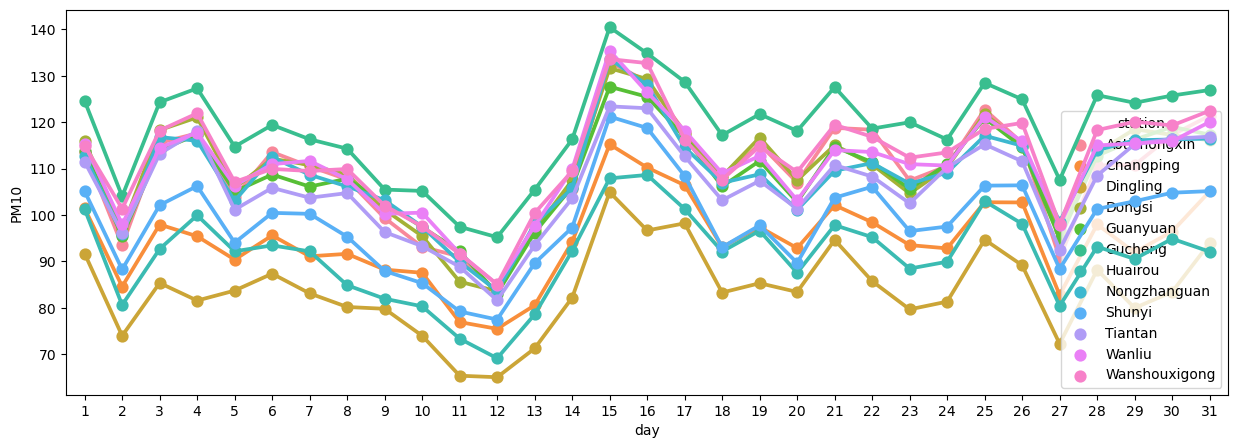

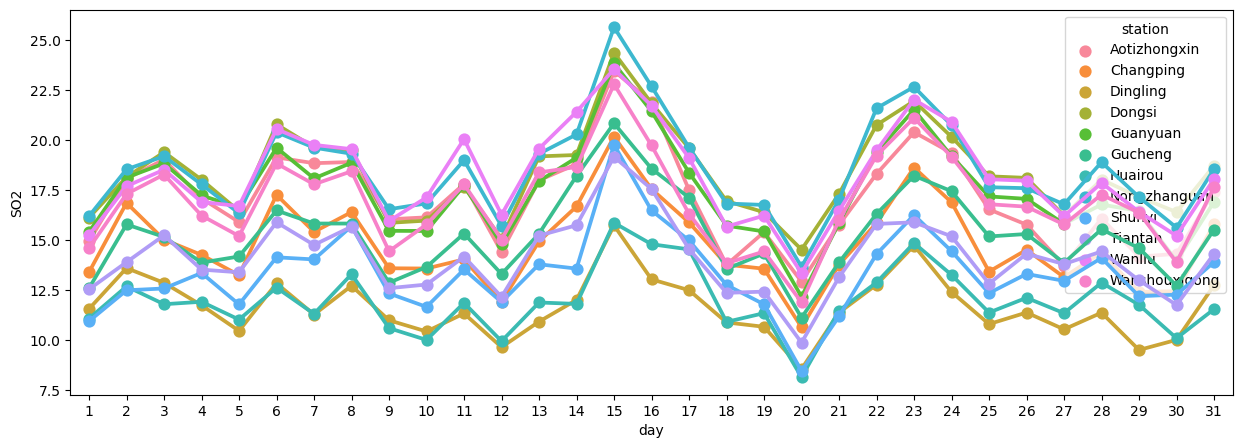

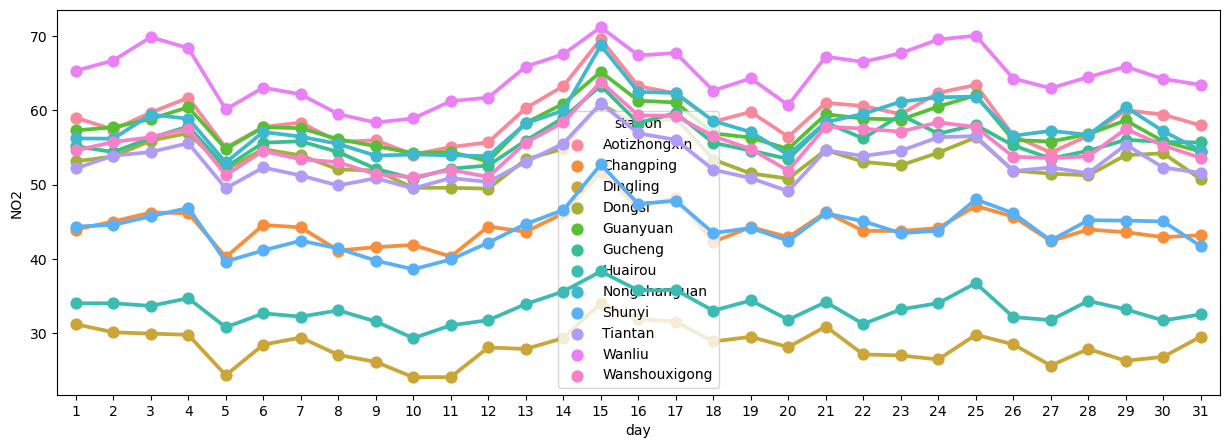

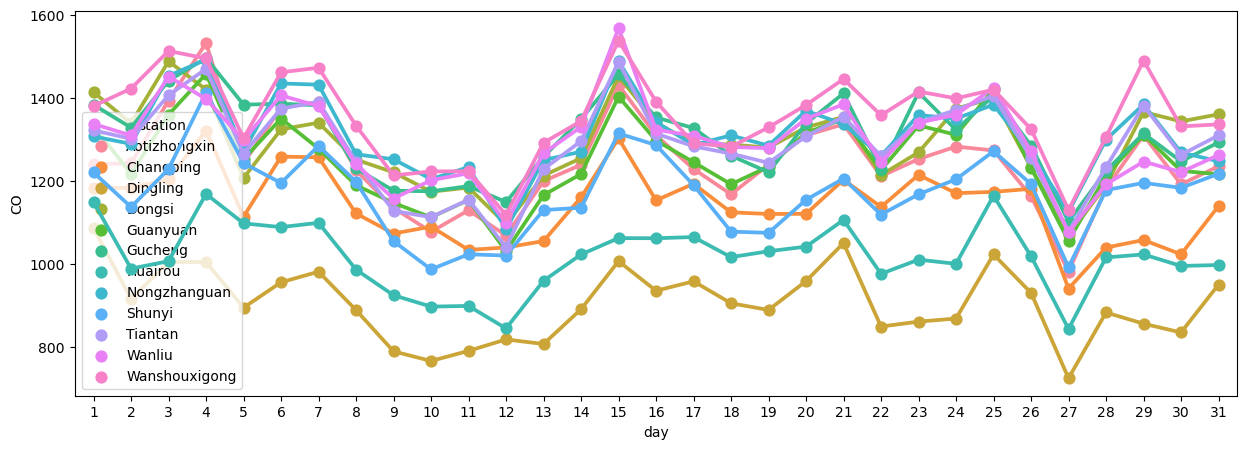

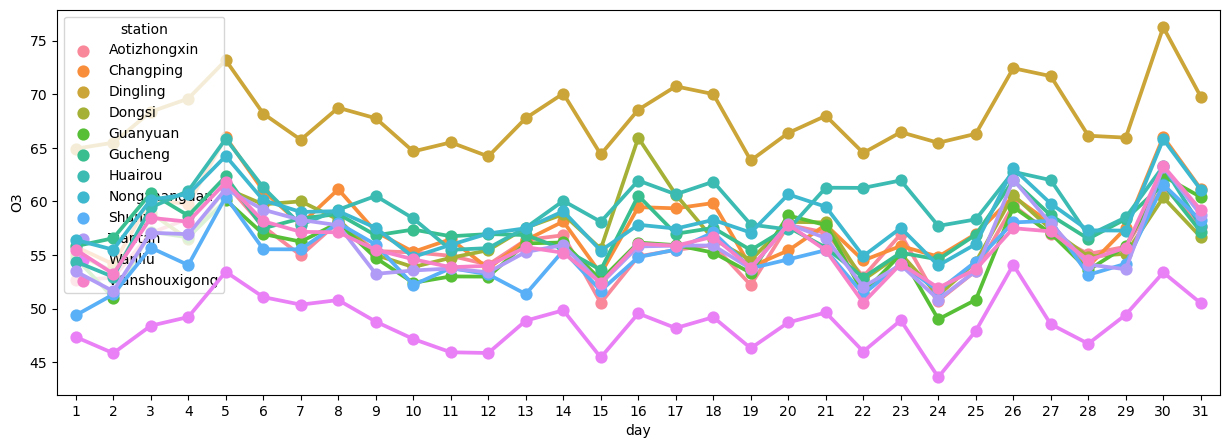

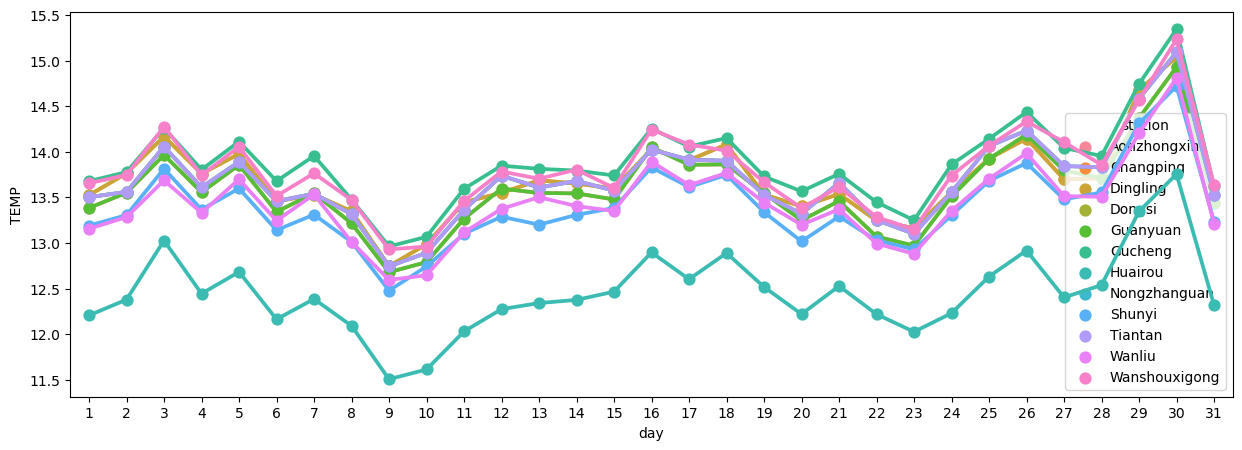

In [13]:

for i in compounds:
    df = data[[i, 'day',
               'station']].groupby(["station",
                                    "day"]).mean().reset_index().sort_values(by=['station',
                                                                                      'day'], ascending=True)
    
    f,ax=plt.subplots(figsize=(15,5))
    sns.pointplot(x='day', y=i, data=df, hue="station")

### Preparar datos para modelado de ML

In [14]:
# safe checkpoint
newData=data.copy()
newData.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Guanyuan
1,2,2013,3,1,1,4.0,4.0,13.0,17.0,300.0,72.0,-1.1,1023.2,-18.2,0.0,N,4.7,Guanyuan
2,3,2013,3,1,2,3.0,3.0,10.0,19.0,300.0,69.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Guanyuan
3,4,2013,3,1,3,3.0,6.0,7.0,24.0,400.0,62.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Guanyuan
4,5,2013,3,1,4,3.0,6.0,5.0,14.0,400.0,71.0,-2.0,1025.2,-19.5,0.0,N,2.0,Guanyuan


Dado que nuestro analizis de datos nos indica correlaciones entre varias variables primero vamos a eliminar varias de ellas y las que no sean utiles para el calculo del AQI por dia considerando la tabla de EPA's
https://www.researchgate.net/figure/EPAs-breakpoint-and-AQI-Index_tbl1_315006128

In [15]:
dataForModel= newData.drop(['PM10','CO','NO2','SO2','No','station','wd','TEMP','hour','RAIN','WSPM','DEWP','PRES'], axis=1)
dataForModel.head()
dataForModel.describe()

,year,month,day,PM2.5,O3
count,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000
mean,2014.662560,6.522930,15.729637,79.278489,56.981874
std,1.177198,3.448707,8.800102,80.056799,55.802413
min,2013.000000,1.000000,1.000000,2.000000,0.214200
25%,2014.000000,4.000000,8.000000,21.000000,12.000000
50%,2015.000000,7.000000,16.000000,55.000000,45.000000
75%,2016.000000,10.000000,23.000000,109.000000,80.000000
max,2017.000000,12.000000,31.000000,999.000000,1071.000000


Create a new variable AQI from PM2.5 and O3

In [16]:
# Calculate AQI based on PM2.5 and O3 values using EPA's breakpoints
def calculate_aqi(pm25, o3):
    # Calculate AQI for PM2.5
    pm25_aqi = calculate_pm25_aqi(pm25)

    # Calculate AQI for O3
    o3_aqi = calculate_o3_aqi(o3)

    # Final AQI is the maximum of PM2.5 AQI and O3 AQI
    aqi = max(pm25_aqi, o3_aqi)
    return aqi

# Calculate AQI for PM2.5 based on EPA's breakpoints
def calculate_pm25_aqi(pm25):
    pm25_breakpoints = [
        (0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 350.4, 301, 400),
        (350.5, 500.4, 401, 500)
    ]

    pm25_aqi = calculate_aqi_from_breakpoints(pm25, pm25_breakpoints)
    return pm25_aqi

# Calculate AQI for O3 based on EPA's breakpoints
def calculate_o3_aqi(o3):
    o3_breakpoints = [
        (0, 0.054, 0, 50),
        (0.055, 0.070, 51, 100),
        (0.071, 0.085, 101, 150),
        (0.086, 0.105, 151, 200),
        (0.106, 0.200, 201, 300),
        (0.201, 0.404, 301, 400),
        (0.405, 0.504, 401, 500)
    ]

    o3_aqi = calculate_aqi_from_breakpoints(o3, o3_breakpoints)
    return o3_aqi

# Helper function to calculate AQI from breakpoints
def calculate_aqi_from_breakpoints(value, breakpoints):
    aqi = 0
    for low, high, aqi_low, aqi_high in breakpoints:
        if low <= value <= high:
            aqi = ((aqi_high - aqi_low) / (high - low)) * (value - low) + aqi_low
            break
    return aqi

In [17]:
# Apply the calculation and categorize AQI into respective categories
dataForModel["AQI"] = dataForModel.apply(lambda row: calculate_aqi(row["PM2.5"], row["O3"]), axis=1)
dataForModel.describe()

,year,month,day,PM2.5,O3,AQI
count,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000
mean,2014.662560,6.522930,15.729637,79.278489,56.981874,137.811226
std,1.177198,3.448707,8.800102,80.056799,55.802413,81.432962
min,2013.000000,1.000000,1.000000,2.000000,0.214200,0.000000
25%,2014.000000,4.000000,8.000000,21.000000,12.000000,69.716738
50%,2015.000000,7.000000,16.000000,55.000000,45.000000,149.015075
75%,2016.000000,10.000000,23.000000,109.000000,80.000000,178.623815
max,2017.000000,12.000000,31.000000,999.000000,1071.000000,499.735824


In [18]:
# Define the AQI thresholds for each category
thresholds = {
    "Good": (0, 50),
    "Moderate": (51, 100),
    "Little Unhealthy": (101, 150),
    "Unhealthy": (151, 200),
    "Very Unhealthy": (201, 300),
    "Hazardous": (301, np.inf)
}

# Function to transform AQI values to labels
def transform_aqi_to_label(aqi):
    for label, (lower, upper) in thresholds.items():
        if lower <= aqi <= upper:
            return label
    return "Unknown"

# Apply transformation to the AQI column
dataForModel["AQI_LABEL"] = dataForModel["AQI"].apply(transform_aqi_to_label)
dataForModel.head()

,year,month,day,PM2.5,O3,AQI,AQI_LABEL
0,2013,3,1,4.0,69.0,16.666667,Good
1,2013,3,1,4.0,72.0,16.666667,Good
2,2013,3,1,3.0,69.0,12.500000,Good
3,2013,3,1,3.0,62.0,12.500000,Good
4,2013,3,1,3.0,71.0,12.500000,Good


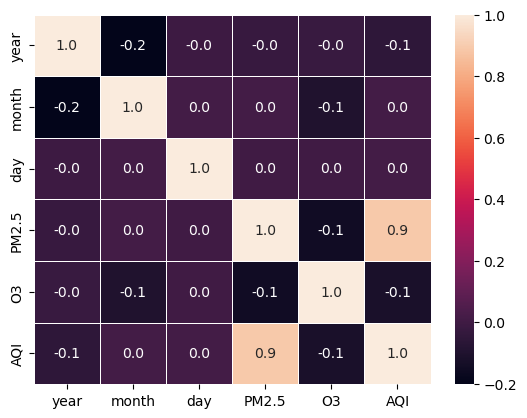

In [19]:
# Verify correlation between fields again
sns.heatmap(dataForModel.corr(),
            annot=True, linewidths=.5, fmt= '.1f')
plt.show()

## Separar data entre entrenamiento y Testing


In [20]:
import statsmodels 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
# para eliminar el año hacer evaluacion por año, por mes y por dia
# create input and output
X= dataForModel.drop(['AQI','AQI_LABEL'], axis=1)
X= sm.add_constant(X)
Y =dataForModel['AQI']

X_train , X_test, y_train,y_test = train_test_split( X, Y, test_size = 0.3)

print(X_train.shape , X_test.shape, y_train.shape,y_test.shape)

(294537, 6) (126231, 6) (294537,) (126231,)


## Crear modelo

Ordinary Least Squares (OLS) method to perform linear regression analysis using the statsmodels library.

In [21]:
#MODEL-1 : MLR MODEL

# Select columns from X_train that have data types other than 'object'
X_train_ex_object = X_train.select_dtypes(exclude='object')

print(X_train_ex_object)

# Create an OLS model using the selected predictor variables and fit it to the training data
ols_model = sm.OLS(y_train, X_train_ex_object).fit()

# Print the summary statistics of the fitted OLS model
ols_model.summary()

       const  year  month  day  PM2.5     O3
28512    1.0  2016      6    1   26.0   41.0
28596    1.0  2016      6    4   85.0  211.0
27389    1.0  2016      4   15   18.0   22.0
198      1.0  2013      3    9   96.0  106.0
14087    1.0  2014     10    8  373.0    2.0
...      ...   ...    ...  ...    ...    ...
25239    1.0  2016      1   16  106.0   27.0
27234    1.0  2016      4    8   29.0  100.0
1578     1.0  2013      5    5  217.0  222.0
23491    1.0  2015     11    4  234.0    2.0
1798     1.0  2013      5   14   81.0   92.0

[294537 rows x 6 columns]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    AQI   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                 2.357e+05
Date:                Wed, 12 Jul 2023   Prob (F-statistic):               0.00
Time:                        23:54:38   Log-Likelihood:            -1.4764e+06
No. Observations:              294537   AIC:                         2.953e+06
Df Residuals:                  294531   BIC:                         2.953e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3994.6326    117.264     34.065      0.000    3764.798    4224.467
year          -1.9510      0.058    -33.529      0.000      -2.065      -1.837
month         -0.0696      0.020     -3.484      0.000      -0.109      -0.030
day            0.0751      0.008      9.864      0.000       0.060       0.090
PM2.5          0.9121      0.001   1073.548      0.000       0.910       0.914
O3             0.0142      0.001     11.606      0.000       0.012       0.017
==============================================================================
Omnibus:                   443954.614   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        295727218.833
Skew:                          -9.278   Prob(JB):                         0.00
Kurtosis:                     157.119   Cond. No.                     3.53e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.53e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Interpretation: The R-squared value obtained from this model is 0.804 which means that the above model explains 80% of the variation in AQI

Durbin-Watson: Test is used to check the autocorrelation between the residuals.

    If the Durbin-Watson test statistic is near to 2: no autocorrelation
    If the Durbin-Watson test statistic is between 0 and 2: positive autocorrelation
    If the Durbin-Watson test statistic is between 2 and 4: negative autocorrelation
    
The test statistic of Model summary is between 0 and 2 (= 1.997) which means there is autocorrelation.

Condition Number (CN): The Condition Number (CN) is used to check the multicollinearity.

    If CN < 100: no multicollinearity
    If CN is between 100 and 1000: moderate multicollinearity<br>
    If CN > 1000: severe multicollinearity
    The condition number is large, 3.31e+05. This indicates that there is strong multicollinearity
we have 310 so there is a moderate multicollinearity 

In [22]:
#MLR MODEL RMSE: ROOT MEAN SQUARE
# Predict target variable using the trained OLS model on the training set
y_train_predict = ols_model.predict(X_train)

# Predict target variable using the trained OLS model on the testing set
y_test_predict = ols_model.predict(X_test)

# Calculate the Root Mean Squared Error (RMSE) on the training set
md1_rmse_train = round(np.sqrt(mean_squared_error(y_train, y_train_predict)), 4)
print("Root Mean Squared Error (RMSE) on training set: ", md1_rmse_train)

# Calculate the Root Mean Squared Error (RMSE) on the testing set
md1_rmse_test = round(np.sqrt(mean_squared_error(y_test, y_test_predict)), 4)
print("Root Mean Squared Error (RMSE) on testing set: ", md1_rmse_test)

Root Mean Squared Error (RMSE) on training set:  36.3714
Root Mean Squared Error (RMSE) on testing set:  37.6597


RMSE on the training set: 36.1202
This value represents the average difference between the predicted values and the actual values of the target variable (AQI) on the training set. It indicates that, on average, the predictions of the model on the training set have an error of approximately 36.1202 AQI units.

RMSE on the testing set: 38.4688
This value represents the average difference between the predicted values and the actual values of the target variable (AQI) on the testing set. It indicates that, on average, the predictions of the model on the testing set have an error of approximately 38.4688 AQI units.

Ideally, we would want the RMSE to be as low as possible, indicating that the model is accurately predicting the target variable. However, the interpretation of the RMSE values depends on the context of your specific problem and the scale of the target variable (AQI).

In [23]:
model=ols_model
# Create a DataFrame to store the summary statistics of the model
summary_model = pd.DataFrame({
    'Model Name': ['MLR MODEL'],  # Name of the model
    'R Square': [model.rsquared],  # R-squared value of the model
    'Adj R Square': [model.rsquared_adj],  # Adjusted R-squared value of the model
    'Prob (F-statistic)': [model.f_pvalue],  # Probability of the F-statistic
    'Cn': [model.condition_number],  # Condition number of the model
    'Prob(JB)': [0.00],  # Probability of the Jarque-Bera test for normality
    'D-W': [1.997],  # Durbin-Watson statistic
    'RMSE train': md1_rmse_train,  # RMSE on the training set
    'RMSE test': md1_rmse_test  # RMSE on the testing set
})
summary_model

,Model Name,R Square,Adj R Square,Prob (F-statistic),Cn,Prob(JB),D-W,RMSE train,RMSE test
0,MLR MODEL,0.800076,0.800073,0.0,3.529366e+06,0.0,1.997,36.3714,37.6597


Interpretation:

R Square (R-squared): R-squared is a measure of how well the model fits the observed data. It represents the proportion of the variance in the target variable that is explained by the predictor variables. The R-squared value ranges from 0 to 1, where 0 indicates that the predictor variables do not explain any of the variance, and 1 indicates a perfect fit. A higher R-squared value indicates a better fit of the model to the data.

Adj R Square (Adjusted R-squared): Adjusted R-squared takes into account the number of predictor variables and the sample size when assessing the goodness of fit. It penalizes the addition of unnecessary variables that do not contribute significantly to the model's performance. The adjusted R-squared value adjusts the R-squared value by considering the complexity of the model and provides a more reliable measure of the model's goodness of fit.

Prob (F-statistic): This field represents the probability associated with the F-statistic. The F-statistic assesses the overall significance of the regression model by comparing the variability explained by the model to the variability unexplained. A low probability (typically below a predetermined significance level, e.g., 0.05) suggests that the model as a whole is statistically significant and provides valuable information for predicting the target variable.

Cn (Condition Number): The condition number is a measure of the sensitivity of the model's predictions to changes in the input variables. It assesses the multicollinearity (correlation) among the predictor variables. A high condition number indicates a high degree of multicollinearity, which can lead to instability in the model's estimates.

Prob(JB) (Jarque-Bera Test Probability): The Jarque-Bera test is a statistical test used to assess whether the residuals (errors) of the model follow a normal distribution. A low probability (e.g., 0.05) suggests that the residuals do not follow a normal distribution, indicating a violation of the assumption of normality in the model.

D-W (Durbin-Watson Statistic): The Durbin-Watson statistic is used to detect the presence of autocorrelation (serial correlation) in the residuals. It measures the degree of correlation between adjacent residuals. The D-W statistic ranges from 0 to 4, with a value around 2 indicating no autocorrelation. A value significantly lower than 2 suggests positive autocorrelation, while a value significantly higher than 2 suggests negative autocorrelation.

RMSE train (Root Mean Squared Error on the training set): RMSE is a measure of the average prediction error of the model. It represents the square root of the average of the squared differences between the predicted and actual values on the training set. A lower RMSE value indicates better accuracy of the model's predictions on the training set.

RMSE test (Root Mean Squared Error on the testing set): This field represents the RMSE on the testing set, which is similar to the RMSE on the training set but calculated using the unseen data in the testing set. The RMSE on the testing set provides an estimate of the model's prediction error when applied to new, unseen data.

Cross validation with Ridge,Lasso and Linear regressions
Ridge Regression:
Ridge Regression is a linear regression model that includes an additional regularization term called "L2 regularization." This term is added to the ordinary least squares (OLS) cost function to impose a penalty on the magnitudes of the regression coefficients. The purpose of Ridge Regression is to prevent overfitting by shrinking the coefficient values towards zero. The regularization term is controlled by a hyperparameter called the "alpha" parameter, which determines the amount of regularization applied. Ridge Regression is effective when dealing with multicollinearity (high correlation between predictor variables) as it can reduce the impact of correlated variables.

Lasso Regression:
Lasso Regression is another linear regression model that includes a different regularization term called "L1 regularization." Similar to Ridge Regression, Lasso Regression adds a penalty term to the OLS cost function, but L1 regularization encourages sparsity by shrinking some coefficients to exactly zero. This property makes Lasso Regression useful for feature selection, as it can effectively eliminate irrelevant or less important predictors from the model. The "alpha" parameter controls the strength of regularization in Lasso Regression. It is particularly effective when dealing with high-dimensional datasets and when the true underlying model is expected to have only a few significant predictors.

Linear Regression:
Linear Regression is the simplest form of regression analysis. It models the linear relationship between a dependent variable (target variable) and one or more independent variables (predictor variables). The goal of Linear Regression is to find the best-fitting line that minimizes the sum of squared residuals between the predicted and actual values. This line is represented by the equation Y = b0 + b1X1 + b2X2 + ... + bn*Xn, where Y is the dependent variable, b0 is the y-intercept, b1 to bn are the regression coefficients, and X1 to Xn are the independent variables. Linear Regression assumes a linear relationship between the predictors and the target variable and assumes that the residuals are normally distributed with constant variance. It does not include any regularization term and is susceptible to overfitting when dealing with high-dimensional datasets or multicollinearity.

In [24]:
# MLR-MODEL CROSS VALIDATION SUMMARY:
# Ridge
from sklearn.linear_model import Ridge
model = Ridge()
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=3)
reg_cv_score = cross_val_score(model, X,Y, cv=cv)
reg_cv_mse = cross_val_score(model, X,Y, cv=cv,scoring='neg_mean_squared_error')
R2 = np.mean(reg_cv_score)
RMSE = np.sqrt(np.abs(np.mean(reg_cv_mse)))
cv_summary_1_0 = pd.DataFrame({'CV Name':['RIDGE REGRESSION'],'R-Square':[R2],'RMSE':[RMSE]})
# Lasso
from sklearn.linear_model import Lasso
model = Lasso()
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=3)
reg_cv_score = cross_val_score(model, X,Y, cv=cv)
reg_cv_mse = cross_val_score(model, X,Y, cv=cv,scoring='neg_mean_squared_error')
R2 = np.mean(reg_cv_score)
RMSE = np.sqrt(np.abs(np.mean(reg_cv_mse)))
cv_summary_1_1 = pd.DataFrame({'CV Name':['LASSO REGRESSION'],'R-Square':[R2],'RMSE':[RMSE]})
# Linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=3)
reg_cv_score = cross_val_score(model, X,Y, cv=cv)
reg_cv_mse = cross_val_score(model, X,Y, cv=cv,scoring='neg_mean_squared_error')
R2 = np.mean(reg_cv_score)
RMSE = np.sqrt(np.abs(np.mean(reg_cv_mse)))
cv_summary_1_2 = pd.DataFrame({'CV Name':['LINEAR REGRESSION'],'R-Square':[R2],'RMSE':[RMSE]})

In [25]:
cv_summary_1 = pd.DataFrame()

cv_summary_1 = cv_summary_1.append(cv_summary_1_0).append(cv_summary_1_1).append(cv_summary_1_2)
cv_summary_1['Model Name'] = 'MLR MODEL'
cv_summary_1 = cv_summary_1.set_index('Model Name')
cv_summary_1

,CV Name,R-Square,RMSE
Model Name,,,
MLR MODEL,RIDGE REGRESSION,0.796191,36.762746
MLR MODEL,LASSO REGRESSION,0.796074,36.773314
MLR MODEL,LINEAR REGRESSION,0.796191,36.762746



An R-squared (R²) in cross-validation indicates that the model explains int that percentage the variability in the target variable using the given predictors.

R-squared is a statistical measure that represents the proportion of the variance in the dependent variable that can be explained by the independent variables in a regression model. It ranges from 0 to 1, indicates fit where the model accounts for all the variability in the dependent variable.

In this case, an RMSE values (approximately 36) suggests that the model's predictions more than 63% of cases of actual values. The small error indicates a high level of precision in the model's predictions, with a very low deviation from the true values.

## Conclusiones

El modelo es un poco pobre para predecir de momento talvez por eliminar mas variables de las que se debia.
